In [1]:
from itertools import chain
#%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as pl
from scipy import stats
from matplotlib import rcParams
import re
import csv
#import MulticoreTSNE
#import mnnpy
import gseapy as gp


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                 8.3.1
anyio               NA
appdirs             1.4.4
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bioservices         1.7.11
bs4                 4.9.3
certifi             2021.05.30
cffi                1.14.6
charset_normalizer  2.0.3
colorama            0.4.4
colorlog            NA
cycler              0.10.0
cython_runtime      NA
dateutil     

In [2]:
filename = '/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/Data/adata_SS2.h5ad'
adata_file = sc.read_h5ad(filename, backed=False)
adata_ss2 = sc.AnnData(X=adata_file.raw.X, var=adata_file.raw.var, obs=adata_file.obs)
adata_ss2.raw = adata_ss2
adata_ss2.X.shape

(3644, 14828)

In [3]:
adata_ss2_day27 = adata_ss2[adata_ss2.obs['day'] == 'day27', :]
adata_ss2_day27

View of AnnData object with n_obs × n_vars = 1674 × 14828
    obs: 'n_genes', 'n_counts', 'condition', 'day', 'platform', 'is_cell_control'

In [4]:
adata_ss2_day27.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [5]:
sc.pp.filter_cells(adata_ss2_day27, min_genes=3000)
sc.pp.filter_genes(adata_ss2_day27, min_cells=10)

filtered out 23 cells that have less than 3000 genes expressed
filtered out 83 genes that are detected in less than 10 cells


In [6]:
adata_ss2_day27

AnnData object with n_obs × n_vars = 1651 × 14745
    obs: 'n_genes', 'n_counts', 'condition', 'day', 'platform', 'is_cell_control'
    var: 'n_cells'

In [7]:
mito_genes = adata_ss2_day27.var_names.str.startswith('MT-')
adata_ss2_day27.obs['percent_mito'] = np.sum(
    adata_ss2_day27[:, mito_genes].X, axis=1).A1 / np.sum(adata_ss2_day27.X, axis=1).A1
adata_ss2_day27.obs['n_counts'] = adata_ss2_day27.X.sum(axis=1).A1

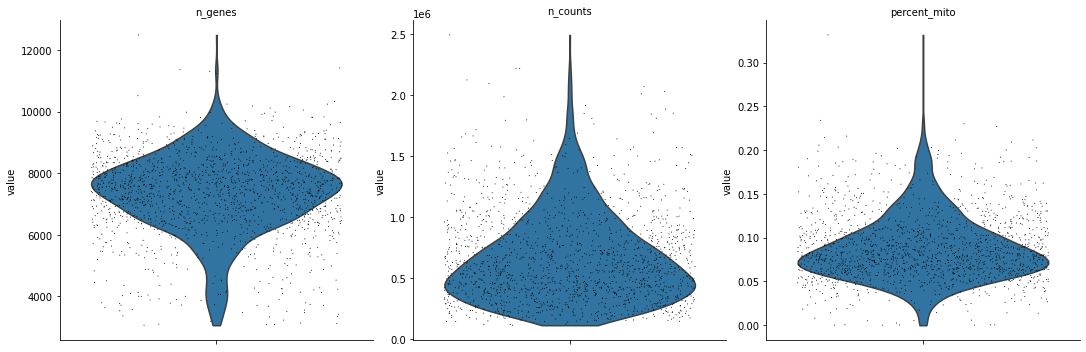

In [8]:
sc.pl.violin(adata_ss2_day27, ['n_genes', 'n_counts', 'percent_mito'], 
	jitter=0.4, multi_panel=True)

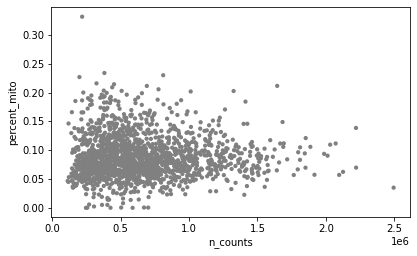

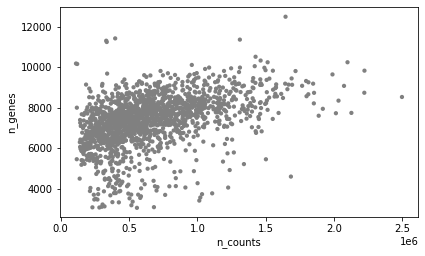

In [9]:
sc.pl.scatter(adata_ss2_day27, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_ss2_day27, x='n_counts', y='n_genes')

In [10]:
adata_ss2_day27= adata_ss2_day27[adata_ss2_day27.obs['n_genes'] < 11000, :]
adata_ss2_day27= adata_ss2_day27[adata_ss2_day27.obs['percent_mito'] < 0.2, :]

In [11]:
adata_ss2_day27

View of AnnData object with n_obs × n_vars = 1632 × 14745
    obs: 'n_genes', 'n_counts', 'condition', 'day', 'platform', 'is_cell_control', 'percent_mito'
    var: 'n_cells'

In [12]:
sc.pp.normalize_per_cell(adata_ss2_day27, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [13]:
sc.pp.log1p(adata_ss2_day27)

In [14]:
pd.crosstab(columns=adata_ss2_day27.obs['condition'],index=adata_ss2_day27.obs['day'])

condition,HNF1B Het KO,HNF1B WT
day,,
day27,748,884


In [15]:
# Calculate HIGHLY VARIABLE GENES
sc.pp.highly_variable_genes(adata_ss2_day27, min_mean=0.0125, max_mean=4, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


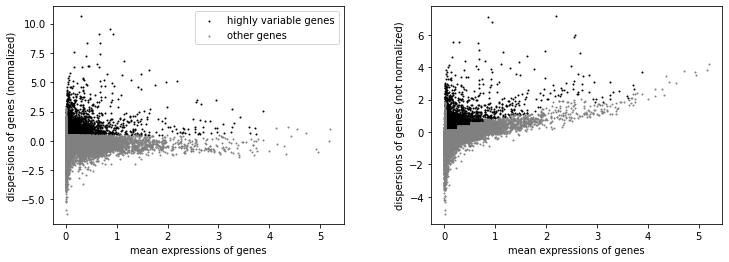

In [16]:
sc.pl.highly_variable_genes(adata_ss2_day27)

In [17]:
# DO ALL REGRESSIONS IN ONLY ONE STEP!!
sc.pp.regress_out(adata_ss2_day27, ['n_counts', 'percent_mito'])
sc.pp.scale(adata_ss2_day27, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:26)


# START HERE! 

In [5]:
results_file = './write/adata_ss2_day27_NORM_REGRESSED_2021-07-17.h5ad'
#adata_ss2_day27.write(results_file)

In [6]:
adata_ss2_day27 = sc.read(results_file)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


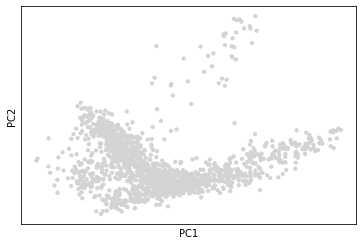

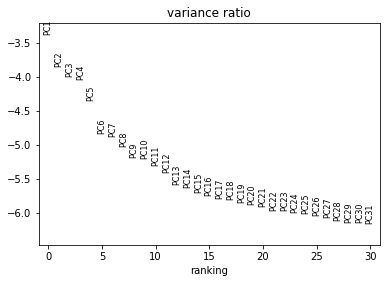

In [7]:
sc.tl.pca(adata_ss2_day27, svd_solver='arpack')
sc.pl.pca(adata_ss2_day27)
sc.pl.pca_variance_ratio(adata_ss2_day27, log=True)

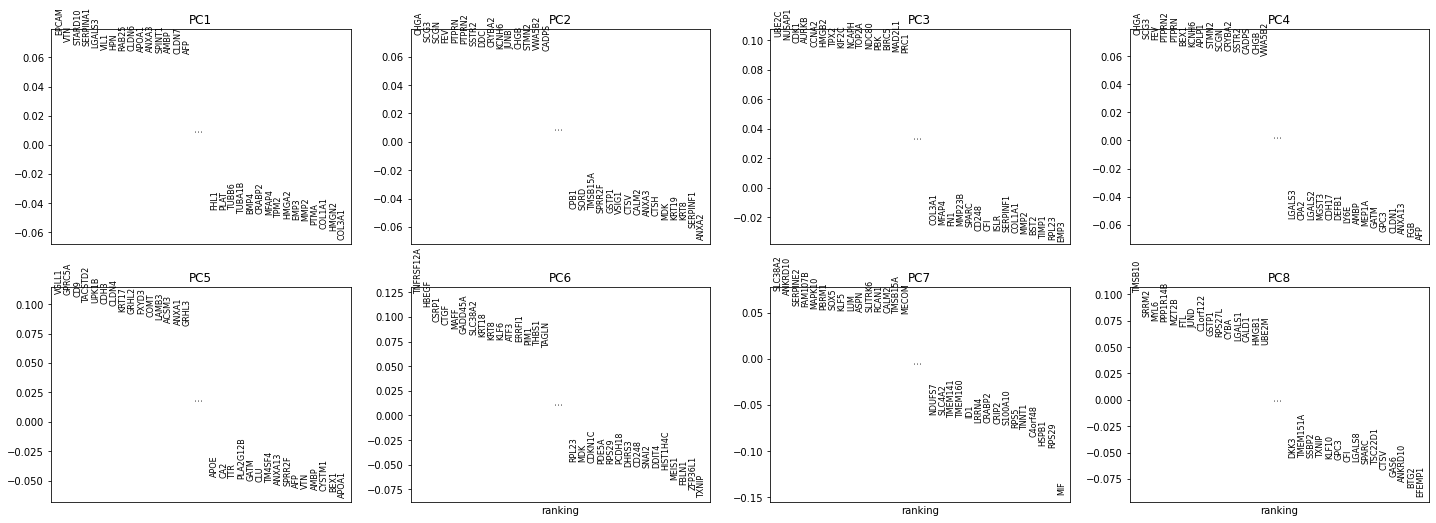

In [8]:
sc.pl.pca_loadings(adata_ss2_day27, components=[1,2,3,4,5,6,7,8])

In [9]:
sc.pp.neighbors(adata_ss2_day27, n_neighbors=25, n_pcs = 5)
sc.tl.louvain(adata_ss2_day27, resolution=0.3)
sc.tl.umap(adata_ss2_day27)

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [10]:
# Custom made - 16 COLOR
colored_groups0 = ['navy', 'steelblue', 'skyblue', 'sienna', 'darkgoldenrod', 'tan', 
                   'gold', 'darkmagenta', 'crimson', 'lightpink', 'darkgreen', 'yellowgreen', 
                   'lightgreen', 'darkorange', 'blueviolet', 'violet']

# Spicy Neutrals
colored_groups1 = ['#AF4425', '#662E1C', '#EBDCB2', '#C9A66B']

#Shages of blues and greens - 6 COLOR
colored_groups2 = ['#00477F', '#4C88BE','#8DC3E9', '#757116', '#AEBC21', '#D9DB56']

# Darkred and Gray - 2 COLOR
colored_groups3 = ['#400000', '#8B8B8B']

# Vibrant Twist - 4 COLOR
colored_groups4 = ['#375E97', '#FB6542', '#FFBB00', '#3F681C']

# Crisp & Dramatic - 4 COLOR
colored_groups5 = ['#505160', '#68829E', '#AEBD38', '#598234']

# Subdued & Professional - 4 COLOR
colored_groups6 = ['#90AFC5', '#336B87', '#2A3132', '#763626']

# Fresh & Energetic - 4 COLOR
colored_groups7 = ['#4CB5F5', '#B7B8B6', '#34675C', '#B3C100']

# Shades of steelblues - - 4 COLOR
colored_groups8 = [(1/255,31/255,75/255), (3/255,77/255,128/255), (100/255,151/255,177/255),
                  (179/255,205/255,224/255)]

#Playful Greens & Blues - 4 COLOR
colored_groups9 = ['#324851', '#86AC41', '#34675C', '#7DA3A1']

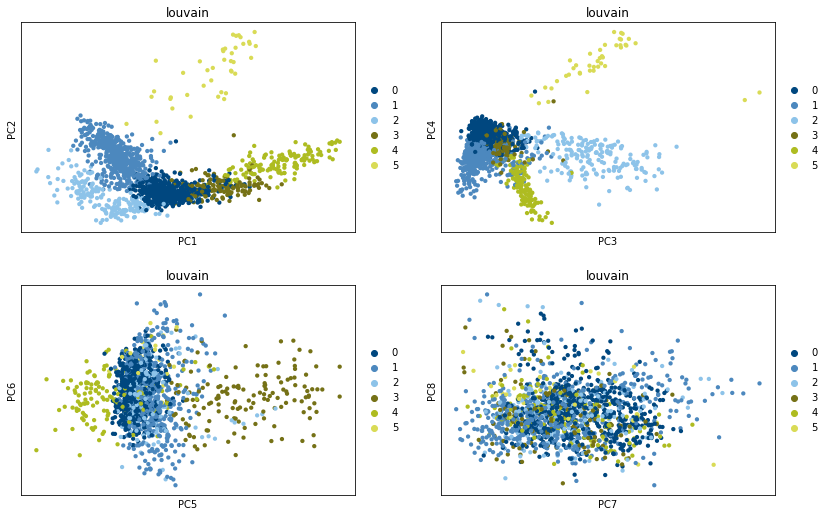

In [11]:
sc.pl.pca(adata_ss2_day27, color='louvain', 
          components = ['1,2','3,4','5,6','7,8'], 
          ncols=2, palette=colored_groups2)

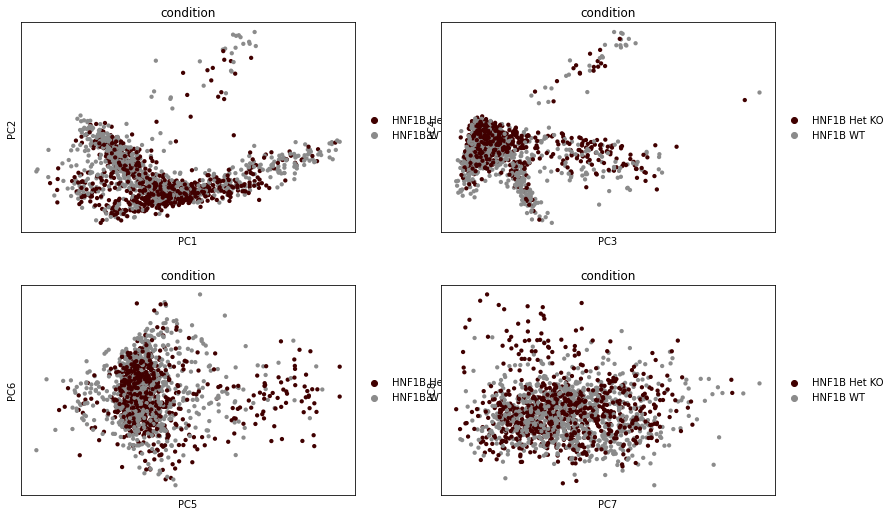

In [12]:
sc.pl.pca(adata_ss2_day27, color='condition', 
          components = ['1,2','3,4','5,6','7,8'], 
          ncols=2, palette=colored_groups3)

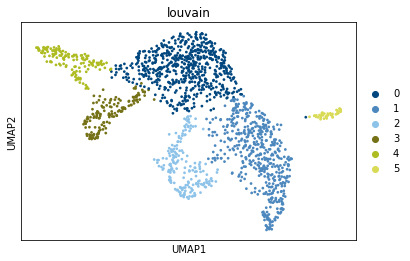

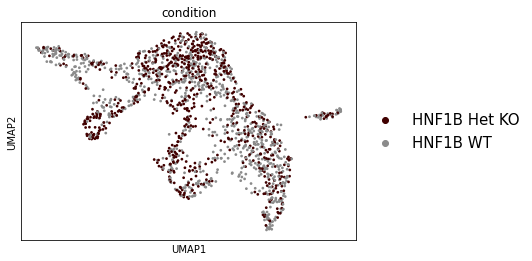

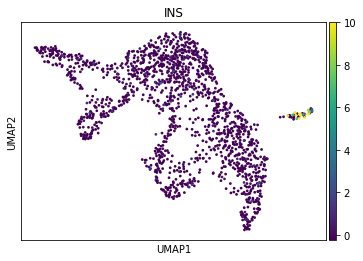

In [13]:
sc.pl.umap(adata_ss2_day27, color=['louvain'], 
           use_raw=False, wspace=0.3, legend_fontsize=10,  size=30,
           palette=colored_groups2)

sc.pl.umap(adata_ss2_day27, color=['condition'], 
           use_raw=False, wspace=0.3, legend_fontsize=15, size=30,
           palette=colored_groups3)

sc.pl.umap(adata_ss2_day27, color=['INS'], 
           use_raw=False, wspace=0.3, legend_fontsize=25,  size=30,
           palette=colored_groups1)

In [14]:
pd.crosstab(columns=adata_ss2_day27.obs['condition'],index=adata_ss2_day27.obs['louvain'])

condition,HNF1B Het KO,HNF1B WT
louvain,,
0,334,285
1,170,325
2,106,86
3,87,58
4,36,103
5,15,27


In [15]:
# Finding marker genes
sc.tl.rank_genes_groups(adata_ss2_day27, 'louvain', method='wilcoxon')

# As an alternative, let us rank genes using logistic regression.
# For instance, this has been suggested by Natranos et al. (2018).
# sc.tl.rank_genes_groups(adata_ss2_day27, 'louvain', method='logreg', solver='saga', multi_class='auto')

# sc.pl.rank_genes_groups(adata_ss2_day27, n_genes=10, sharey=False, fontsize=12)
pd.DataFrame(adata_ss2_day27.uns['rank_genes_groups']['names']).head(20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/HASTER_FerrerColab_2021-07-17/venv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/HASTER_FerrerColab_2021-07-17/venv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/HASTER_FerrerColab_2021-07-17/venv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/HASTER_FerrerColab_2021-07-17/venv/lib/python3.8/site-packages/scanpy/tools/

,0,1,2,3,4,5
0,SERPINF1,COL3A1,HMGB2,CLDN4,AFP,CHGA
1,SORD,HMGA2,MAD2L1,PRSS22,FGB,SCG3
2,VSIG1,MMP2,NUSAP1,CDH1,SERPINA1,PTPRN2
3,BEX1,PLAT,CENPF,GRHL2,VTN,KIF1A
4,APOA1,CDH11,RRM2,S100A11,ANXA13,STMN2
5,SLC22A8,EGR1,UBE2C,FXYD3,TTR,PCSK1N
6,NPW,COL1A1,CENPU,GPRC5A,AMBP,CHGB
7,SEMA3C,MRC2,TK1,CDH3,LGALS3,FEV
8,SALL4,JUNB,CKS1B,COMT,ONECUT2,PTPRN
9,IGFBP5,BMP4,ZWINT,RAB25,CLDN1,INA


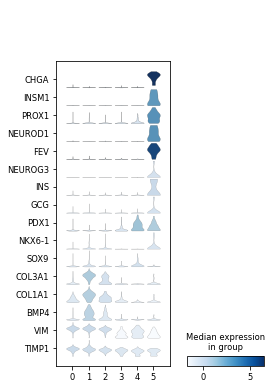

In [16]:
marker_genes = ['CHGA', 'INSM1', 'PROX1', 'NEUROD1', 'FEV',                 
                'NEUROG3', 'INS', 'GCG', 'PDX1', 'NKX6-1', 'SOX9', 
                'COL3A1', 'COL1A1', 'BMP4', 'VIM', 'TIMP1']

sc.pl.stacked_violin(adata_ss2_day27, marker_genes, groupby='louvain', rotation=90, 
                    use_raw=False, swap_axes=True)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


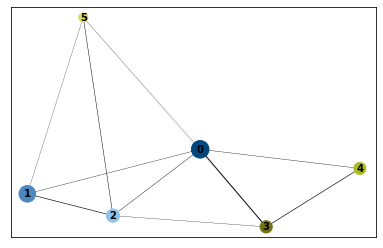

In [17]:
sc.tl.paga(adata_ss2_day27, groups='louvain')
# sc.pl.paga(adata_ss2_day27, color=['day','louvain'], save='_05_PAGA', use_raw=False, show=False)
sc.pl.paga(adata_ss2_day27, color=['louvain'], use_raw=False)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99506515 0.99154264 0.98938125 0.9842132  0.98267317
     0.9734556  0.95966405 0.952136   0.94716746 0.9392358  0.9299729
     0.92237765 0.9100708  0.90795684]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


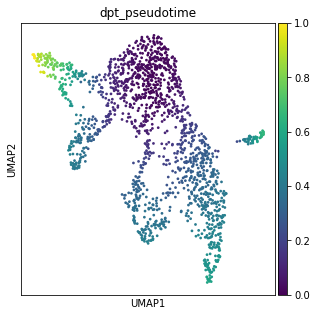

In [18]:
sc.tl.diffmap(adata_ss2_day27)
#cálculo del pseudotime 
#primero hay que elegir un punto de partida, en este caso elijo las células de louvain0

adata_ss2_day27.uns['iroot'] = np.flatnonzero(adata_ss2_day27.obs['louvain'] == '0')[10]
#adata_10x_day13_sincluster3.uns['iroot'] = np.argmax(data_phate.iloc[:,0].values)

sc.tl.dpt(adata_ss2_day27, n_dcs=10)

rcParams['figure.figsize'] = (5, 5)

sc.pl.umap(adata_ss2_day27, color=['dpt_pseudotime'], size=30)

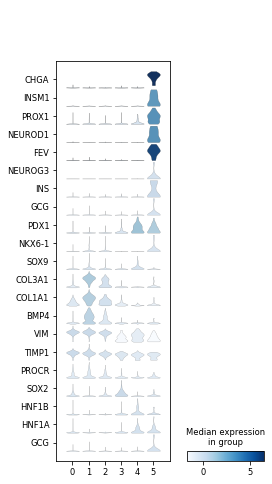

In [19]:
marker_genes = ['CHGA', 'INSM1', 'PROX1', 'NEUROD1', 'FEV',                 
                'NEUROG3', 'INS', 'GCG', 'PDX1', 'NKX6-1', 'SOX9', 
                'COL3A1', 'COL1A1', 'BMP4', 'VIM', 'TIMP1', 
                'PROCR', 'SOX2', 'HNF1B', 'HNF1A', 'GCG']

sc.pl.stacked_violin(adata_ss2_day27, marker_genes, groupby='louvain', rotation=90, 
                    use_raw=False, swap_axes=True)

/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/HASTER_FerrerColab_2021-07-17/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


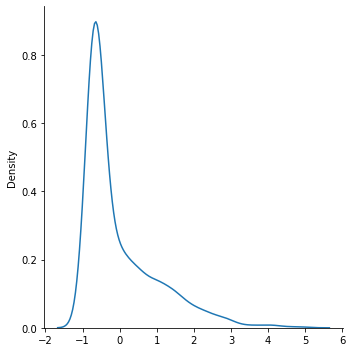

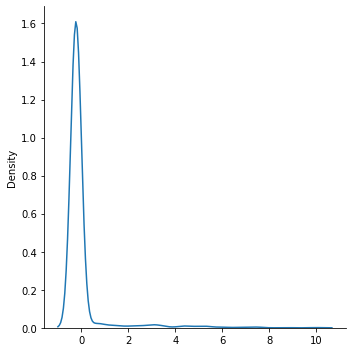

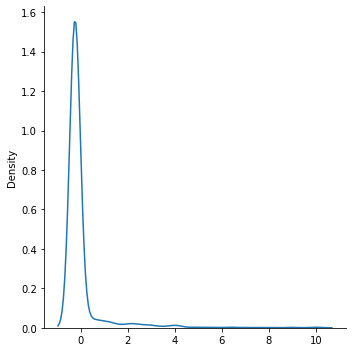

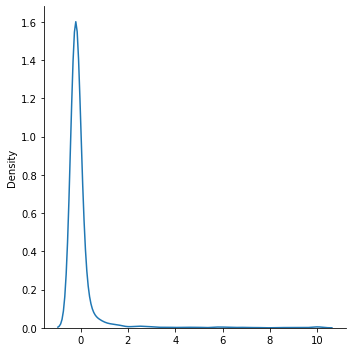

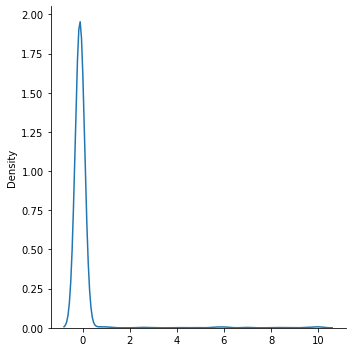

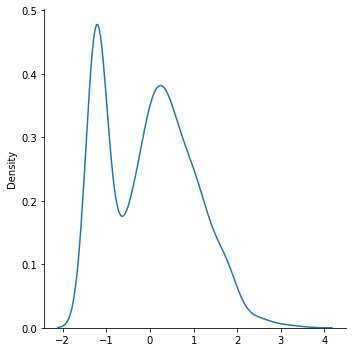

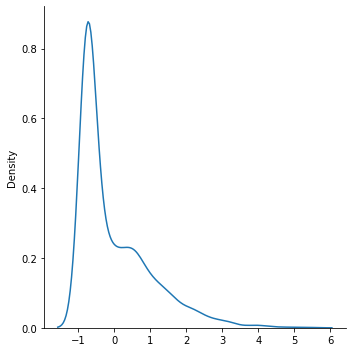

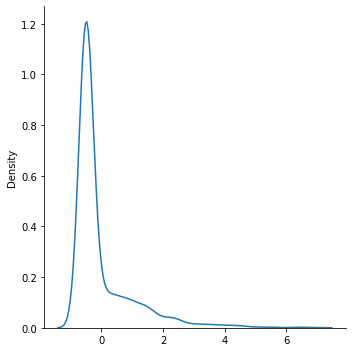

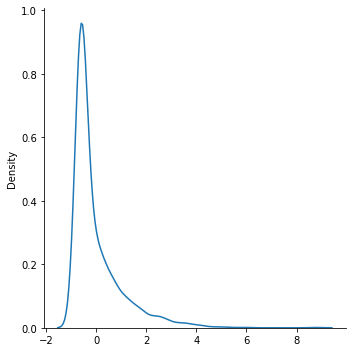

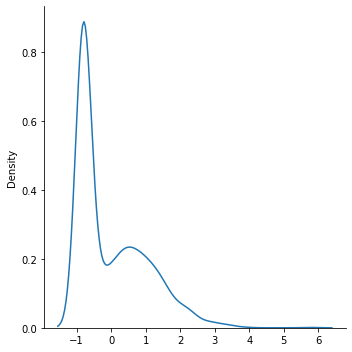

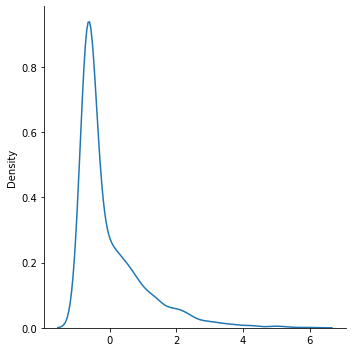

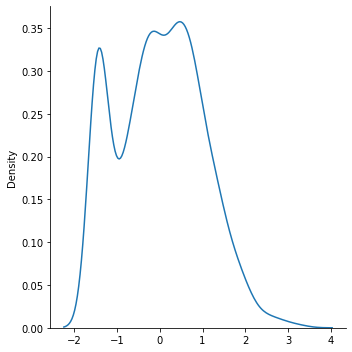

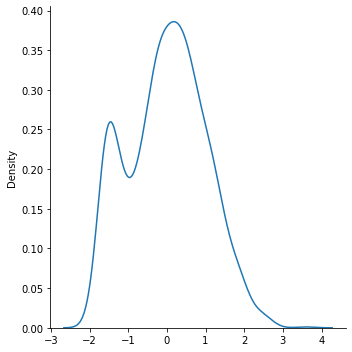

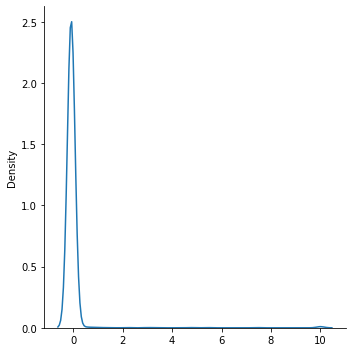

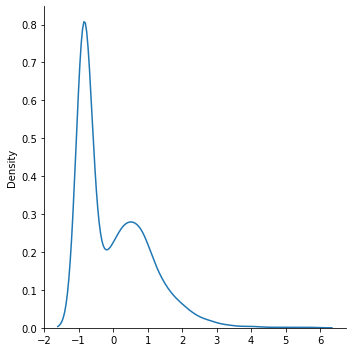

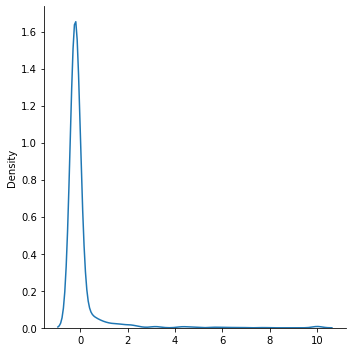

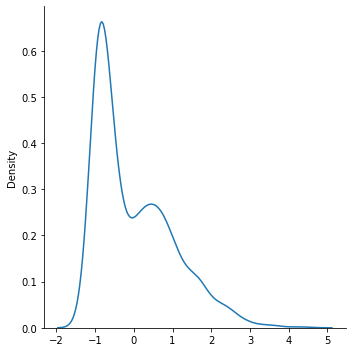

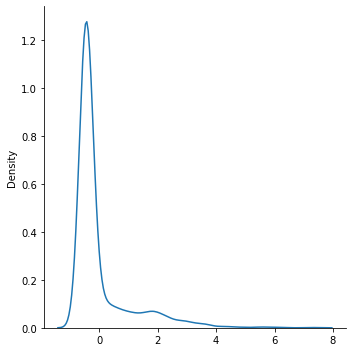

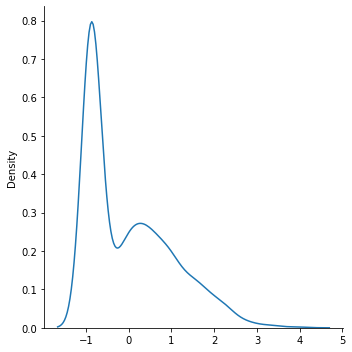

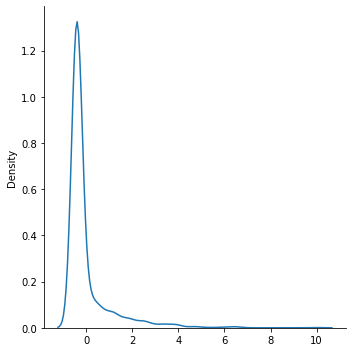

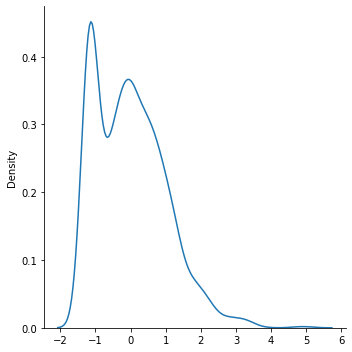

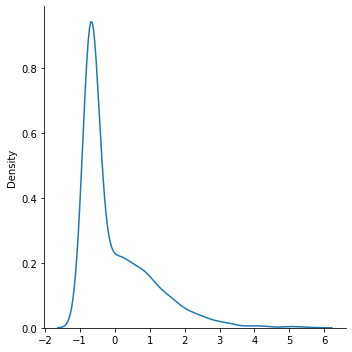

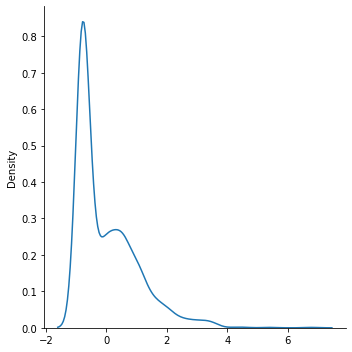

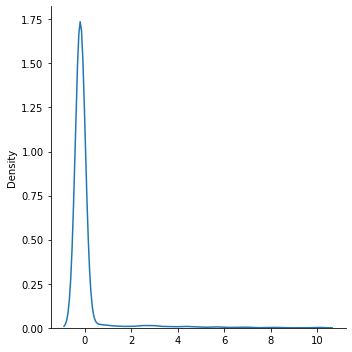

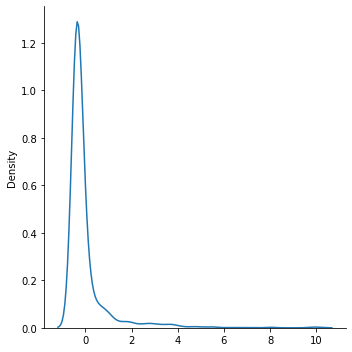

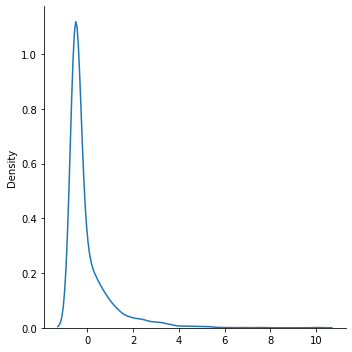

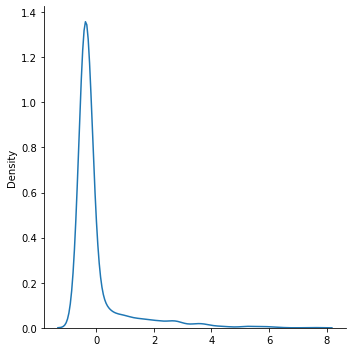

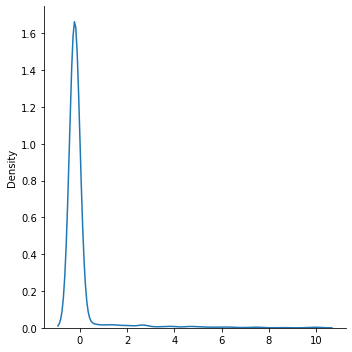

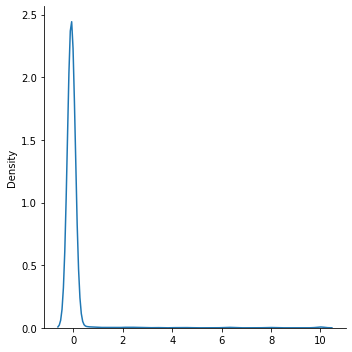

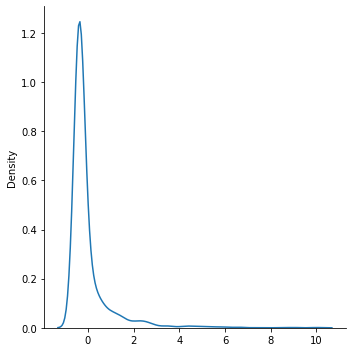

In [20]:
for i in range(30):
    sns.displot(adata_ss2_day27.X.T[i], kind="kde")

In [28]:
adata_ss2_day27.X.shape

(1632, 14745)

In [24]:
adata_ss2_day27

AnnData object with n_obs × n_vars = 1632 × 14745
    obs: 'n_genes', 'n_counts', 'condition', 'day', 'platform', 'is_cell_control', 'percent_mito', 'louvain', 'dpt_pseudotime'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors', 'condition_colors', 'rank_genes_groups', 'paga', 'louvain_sizes', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [20]:
adata_ss2_day27_df = pd.DataFrame(adata_ss2_day27.X,
                      index=adata_ss2_day27.obs.index, columns=adata_ss2_day27.var.index)
adata_ss2_day27_df.head()

index,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,...,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
index,,,,,,,,,,,,,,,,,,,,,
21999_6#10,-0.697906,-0.236415,-0.264576,-0.249178,-0.106101,0.217084,1.273678,-0.478492,1.906011,-0.174044,...,-0.122973,-0.536271,0.360500,-0.462296,-0.322573,0.003303,-0.184213,-0.310351,-0.378754,0.665498
21999_6#100,-0.761169,-0.249890,-0.264107,-0.252716,-0.117080,-1.270441,-0.790057,-0.474273,-0.676267,-0.821240,...,-0.545576,-0.529863,-0.554667,-0.490199,-0.353133,-0.461524,0.746361,-1.471283,-0.380206,-0.918484
21999_6#101,2.178948,-0.226346,-0.253269,-0.227997,-0.110539,-1.228129,1.159106,1.413200,-0.542272,0.550115,...,1.057840,-0.522267,-0.545954,-0.494891,-0.338195,-0.476925,3.250369,-0.466631,-0.340947,0.741326
21999_6#103,-0.610853,-0.208519,-0.240561,-0.039583,-0.109569,0.732336,0.858316,-0.540593,1.387391,-0.802972,...,-0.518056,-0.509742,-0.541878,-0.516875,-0.339247,0.843226,-0.490699,0.390933,-0.234312,1.304948
21999_6#104,1.437629,-0.220957,-0.258924,-0.234182,-0.099996,-0.820302,-0.769105,1.208828,3.650223,-0.799957,...,-0.514104,-0.533764,-0.537714,-0.458118,-0.307321,-0.462934,-0.485081,0.713302,-0.389741,0.735419


In [21]:
# for each cell get the average expression of the Hnf1a target genes
adata_ss2_day27_df['Hnf1a_targets'] = adata_ss2_day27_df.mean(axis=1)

In [23]:
adata_ss2_day27_df.head()

index,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,...,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,Hnf1a_targets
index,,,,,,,,,,,,,,,,,,,,,
21999_6#10,-0.697906,-0.236415,-0.264576,-0.249178,-0.106101,0.217084,1.273678,-0.478492,1.906011,-0.174044,...,-0.536271,0.360500,-0.462296,-0.322573,0.003303,-0.184213,-0.310351,-0.378754,0.665498,0.011397
21999_6#100,-0.761169,-0.249890,-0.264107,-0.252716,-0.117080,-1.270441,-0.790057,-0.474273,-0.676267,-0.821240,...,-0.529863,-0.554667,-0.490199,-0.353133,-0.461524,0.746361,-1.471283,-0.380206,-0.918484,-0.229612
21999_6#101,2.178948,-0.226346,-0.253269,-0.227997,-0.110539,-1.228129,1.159106,1.413200,-0.542272,0.550115,...,-0.522267,-0.545954,-0.494891,-0.338195,-0.476925,3.250369,-0.466631,-0.340947,0.741326,-0.004588
21999_6#103,-0.610853,-0.208519,-0.240561,-0.039583,-0.109569,0.732336,0.858316,-0.540593,1.387391,-0.802972,...,-0.509742,-0.541878,-0.516875,-0.339247,0.843226,-0.490699,0.390933,-0.234312,1.304948,-0.024414
21999_6#104,1.437629,-0.220957,-0.258924,-0.234182,-0.099996,-0.820302,-0.769105,1.208828,3.650223,-0.799957,...,-0.533764,-0.537714,-0.458118,-0.307321,-0.462934,-0.485081,0.713302,-0.389741,0.735419,-0.027797


In [24]:
adata_ss2_day27.obs.head()

,n_genes,n_counts,condition,day,platform,is_cell_control,percent_mito,louvain,dpt_pseudotime
index,,,,,,,,,
21999_6#10,8665,445002.40625,HNF1B WT,day27,SS2,False,0.087050,3,0.142507
21999_6#100,3712,566610.50000,HNF1B WT,day27,SS2,False,0.069242,0,0.121398
21999_6#101,7321,651300.06250,HNF1B WT,day27,SS2,False,0.092418,0,0.027473
21999_6#103,8762,820785.37500,HNF1B WT,day27,SS2,False,0.108400,0,0.102887
21999_6#104,6375,460960.71875,HNF1B WT,day27,SS2,False,0.103634,1,0.300462


In [25]:
# Merge with tsne to plot the average zscore on the tsne plot
adata_ss2_day27_HNF1ATargets = adata_ss2_day27.obs.merge(adata_ss2_day27_df[['Hnf1a_targets']], on=('index'), how='left').copy()

In [26]:
adata_ss2_day27_HNF1ATargets

,n_genes,n_counts,condition,day,platform,is_cell_control,percent_mito,louvain,dpt_pseudotime,Hnf1a_targets
index,,,,,,,,,,
21999_6#10,8665,445002.40625,HNF1B WT,day27,SS2,False,0.087050,3,0.142507,0.011397
21999_6#100,3712,566610.50000,HNF1B WT,day27,SS2,False,0.069242,0,0.121398,-0.229612
21999_6#101,7321,651300.06250,HNF1B WT,day27,SS2,False,0.092418,0,0.027473,-0.004588
21999_6#103,8762,820785.37500,HNF1B WT,day27,SS2,False,0.108400,0,0.102887,-0.024414
21999_6#104,6375,460960.71875,HNF1B WT,day27,SS2,False,0.103634,1,0.300462,-0.027797
...,...,...,...,...,...,...,...,...,...,...
22710_3#86,4534,404667.21875,HNF1B Het KO,day27,SS2,False,0.014169,2,0.318931,-0.093325
22710_3#87,6087,709856.18750,HNF1B Het KO,day27,SS2,False,0.091957,0,0.049940,-0.040395
22710_3#88,7196,568595.43750,HNF1B Het KO,day27,SS2,False,0.099938,2,0.133002,0.007015


In [33]:
pd.crosstab(columns=adata_ss2_day27_HNF1ATargets['condition'],index=adata_ss2_day27_HNF1ATargets['louvain'])

condition,HNF1B Het KO,HNF1B WT
louvain,,
0,334,285
1,170,325
2,106,86
3,87,58
4,36,103
5,15,27


In [48]:
endocrine_ctrl = adata_ss2_day27_HNF1ATargets[(adata_ss2_day27_HNF1ATargets['louvain'].isin(['5'])) & 
                                              (adata_ss2_day27_HNF1ATargets['condition'] == 'HNF1B WT')]['Hnf1a_targets']
endocrine_het = adata_ss2_day27_HNF1ATargets[(adata_ss2_day27_HNF1ATargets['louvain'].isin(['5'])) & 
                                              (adata_ss2_day27_HNF1ATargets['condition'] == 'HNF1B Het KO')]['Hnf1a_targets']

In [46]:
len(endocrine_ctrl)

27

In [49]:
len(endocrine_het)

15

/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/HASTER_FerrerColab_2021-07-17/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/media/usuario/Datos/eve/ifibyne/1_Genomic/2_OurProjects/2_HNF1B/scRNA-seq/SS2/HASTER_FerrerColab_2021-07-17/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


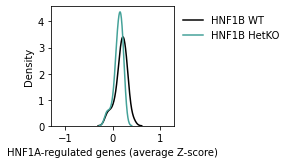

In [59]:
bins=40

fig_dist_beta, ax = plt.subplots(figsize=(2.2,2.2))
sns.distplot(endocrine_ctrl, hist=False, rug=False, kde=True,
             bins=bins,
             color='k',
             label='HNF1B WT',
             ax=ax)
sns.distplot(endocrine_het, hist=False, rug=False, kde=True,
             bins=bins,
             color=sns.color_palette("BrBG", 8)[6],
             label='HNF1B HetKO',
             ax=ax)

handles, labels = ax.get_legend_handles_labels()
#labels = ['Control beta cells', 'HasterpKO beta  cells', "HasterpKO beta' cells"]
ax.set_xlabel('HNF1A-regulated genes (average Z-score)')
#ax.set_yticks(np.arange(0,400,100))
ax.set_xlim(-1.3,1.3)
ax.set_ylabel('Density')
ax.legend(handles, labels, frameon=False, loc=2, bbox_to_anchor=(1,1))

In [51]:
import matplotlib.pyplot as plt